In [ ]:
!unzip data.zip

In [2]:
# 기본 라이브러리
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

# Scikit-learn 라이브러리
from sklearn.model_selection import train_test_split

# PyTorch 및 Torchvision 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# --- 경로 및 하이퍼파라미터 설정 ---

# 데이터 경로 (Colab 또는 로컬 환경에 맞게 수정)
# 예시: './kaggle_3m/'
DATA_PATH = './kaggle_3m/'

# PyTorch 학습을 위한 장치 설정 (GPU 우선 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 하이퍼파라미터
BATCH_SIZE = 16
IMG_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

Using device: cuda


In [4]:
# 전체 데이터 파일 경로 불러오기
all_files = glob(os.path.join(DATA_PATH, '*/*'))

# 이미지와 마스크 경로를 분리하여 데이터프레임 생성
data = []
for file in all_files:
    if 'mask' not in file:
        mask_path = file.replace('.tif', '_mask.tif')
        if mask_path in all_files:
            data.append({'image_path': file, 'mask_path': mask_path})

df = pd.DataFrame(data)

# 데이터셋 분할 (학습, 검증, 테스트)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)


print(f"총 데이터 개수: {len(df)}")
print(f"학습 데이터 개수: {len(train_df)}")
print(f"검증 데이터 개수: {len(val_df)}")
print(f"테스트 데이터 개수: {len(test_df)}")
df.head()

총 데이터 개수: 3929
학습 데이터 개수: 2671
검증 데이터 개수: 472
테스트 데이터 개수: 786


,image_path,mask_path
0,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...
1,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...
2,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...
3,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...
4,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...,./kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW...


--- Sample Data ---


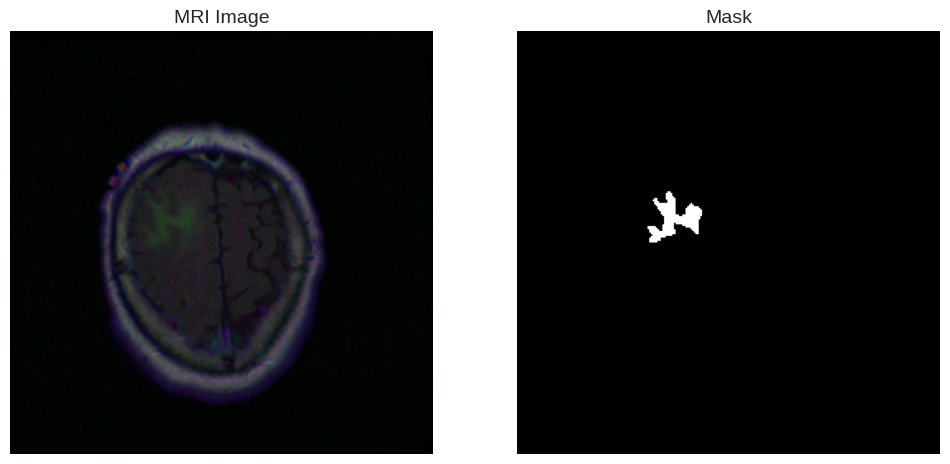

In [5]:
# 샘플 이미지와 마스크 시각화
def show_sample(df, index):
    row = df.iloc[index]
    img = Image.open(row['image_path'])
    mask = Image.open(row['mask_path'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(img, cmap='bone')
    ax1.set_title('MRI Image', fontsize=14)
    ax1.axis('off')

    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask', fontsize=14)
    ax2.axis('off')

    plt.show()

print("--- Sample Data ---")
show_sample(train_df, 0)

In [6]:
# 이미지와 마스크를 위한 Transforms 정의
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Grayscale 이미지이므로 채널 1개
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Custom Dataset 클래스
class BrainMRIDataset(Dataset):
    def __init__(self, df, transform=None, mask_transform=None):
        self.df = df
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert("L") # Grayscale로 로드
        mask = Image.open(row['mask_path']).convert("L")

        if self.transform:
            img = self.transform(img)

        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = mask / 255.0 # 0~1 사이 값으로 정규화

        return img, mask

# Dataset 및 DataLoader 생성
train_dataset = BrainMRIDataset(train_df, transform=transform, mask_transform=mask_transform)
val_dataset = BrainMRIDataset(val_df, transform=transform, mask_transform=mask_transform)
test_dataset = BrainMRIDataset(test_df, transform=transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders are ready.")

DataLoaders are ready.


In [7]:
# U-Net의 기본 구성 블록: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # --- 인코더 (Contracting Path) ---
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)

        # --- 디코더 (Expansive Path) ---
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512) # Skip connection 포함
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)

        # 최종 출력 레이어
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # 인코더
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)

        # 디코더 (스킵 커넥션과 함께)
        u6 = self.up6(c5)
        merge6 = torch.cat([u6, c4], dim=1) # Skip Connection
        c6 = self.conv6(merge6)

        u7 = self.up7(c6)
        merge7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(merge7)

        u8 = self.up8(c7)
        merge8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(merge8)

        u9 = self.up9(c8)
        merge9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(merge9)

        output = self.out(c9)
        return torch.sigmoid(output) # Sigmoid를 통해 0~1 사이의 확률 값으로 출력

# 모델 인스턴스 생성
model = UNet(in_channels=1, out_channels=1).to(device)

In [8]:
# Dice Coefficient (평가지표)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

# Dice Loss (손실 함수)
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = DiceLoss()

In [10]:
# 모델 학습
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    total_train_dice = 0

    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_dice += dice_coefficient(masks, outputs).item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_dice = total_train_dice / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['train_dice'].append(avg_train_dice)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    total_val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            total_val_dice += dice_coefficient(masks, outputs).item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_dice = total_val_dice / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_dice'].append(avg_val_dice)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}")

print("\nTraining finished.")

Training Epoch 1/20:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 0.9986, Train Dice: 0.0014, Val Loss: 1.0000, Val Dice: 0.0000


Training Epoch 2/20:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 0.9981, Train Dice: 0.0019, Val Loss: 0.9972, Val Dice: 0.0028


Training Epoch 3/20:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 0.9956, Train Dice: 0.0044, Val Loss: 0.9991, Val Dice: 0.0009


Training Epoch 4/20:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 0.9996, Train Dice: 0.0004, Val Loss: 0.9998, Val Dice: 0.0002


Training Epoch 5/20:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 0.9998, Train Dice: 0.0002, Val Loss: 0.9989, Val Dice: 0.0011

Training finished.


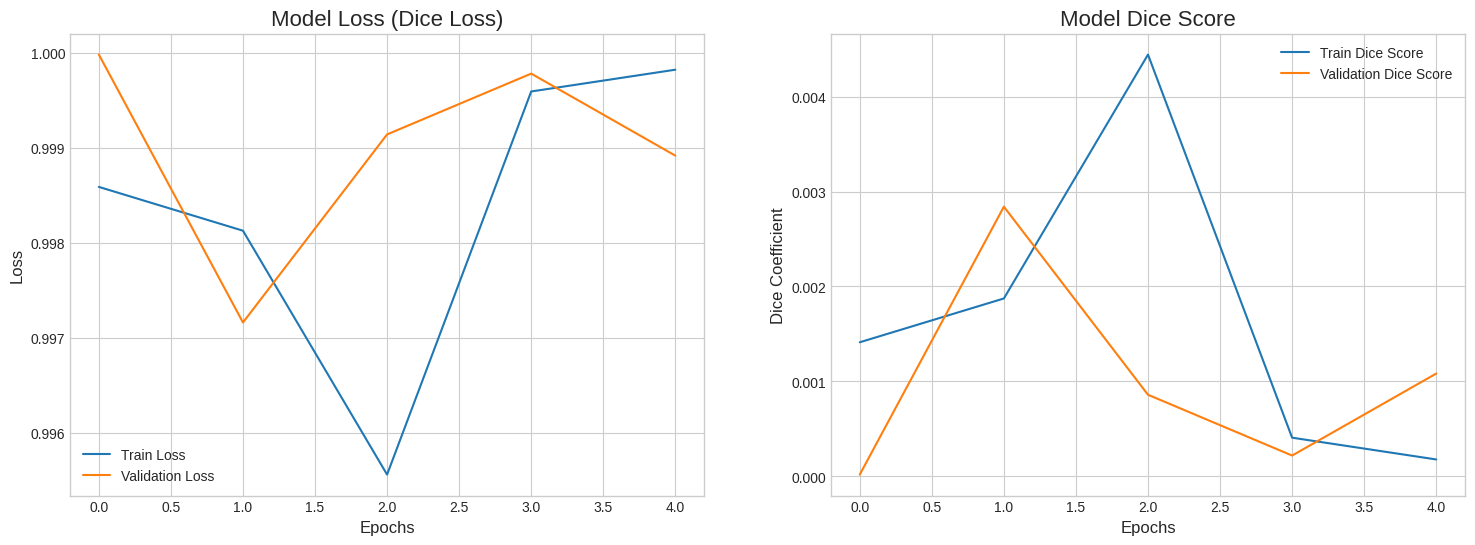

In [11]:
# 학습 과정의 손실 및 Dice Score 변화 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss (Dice Loss)', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()

# Dice Score plot
ax2.plot(history['train_dice'], label='Train Dice Score')
ax2.plot(history['val_dice'], label='Validation Dice Score')
ax2.set_title('Model Dice Score', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Dice Coefficient', fontsize=12)
ax2.legend()

plt.show()

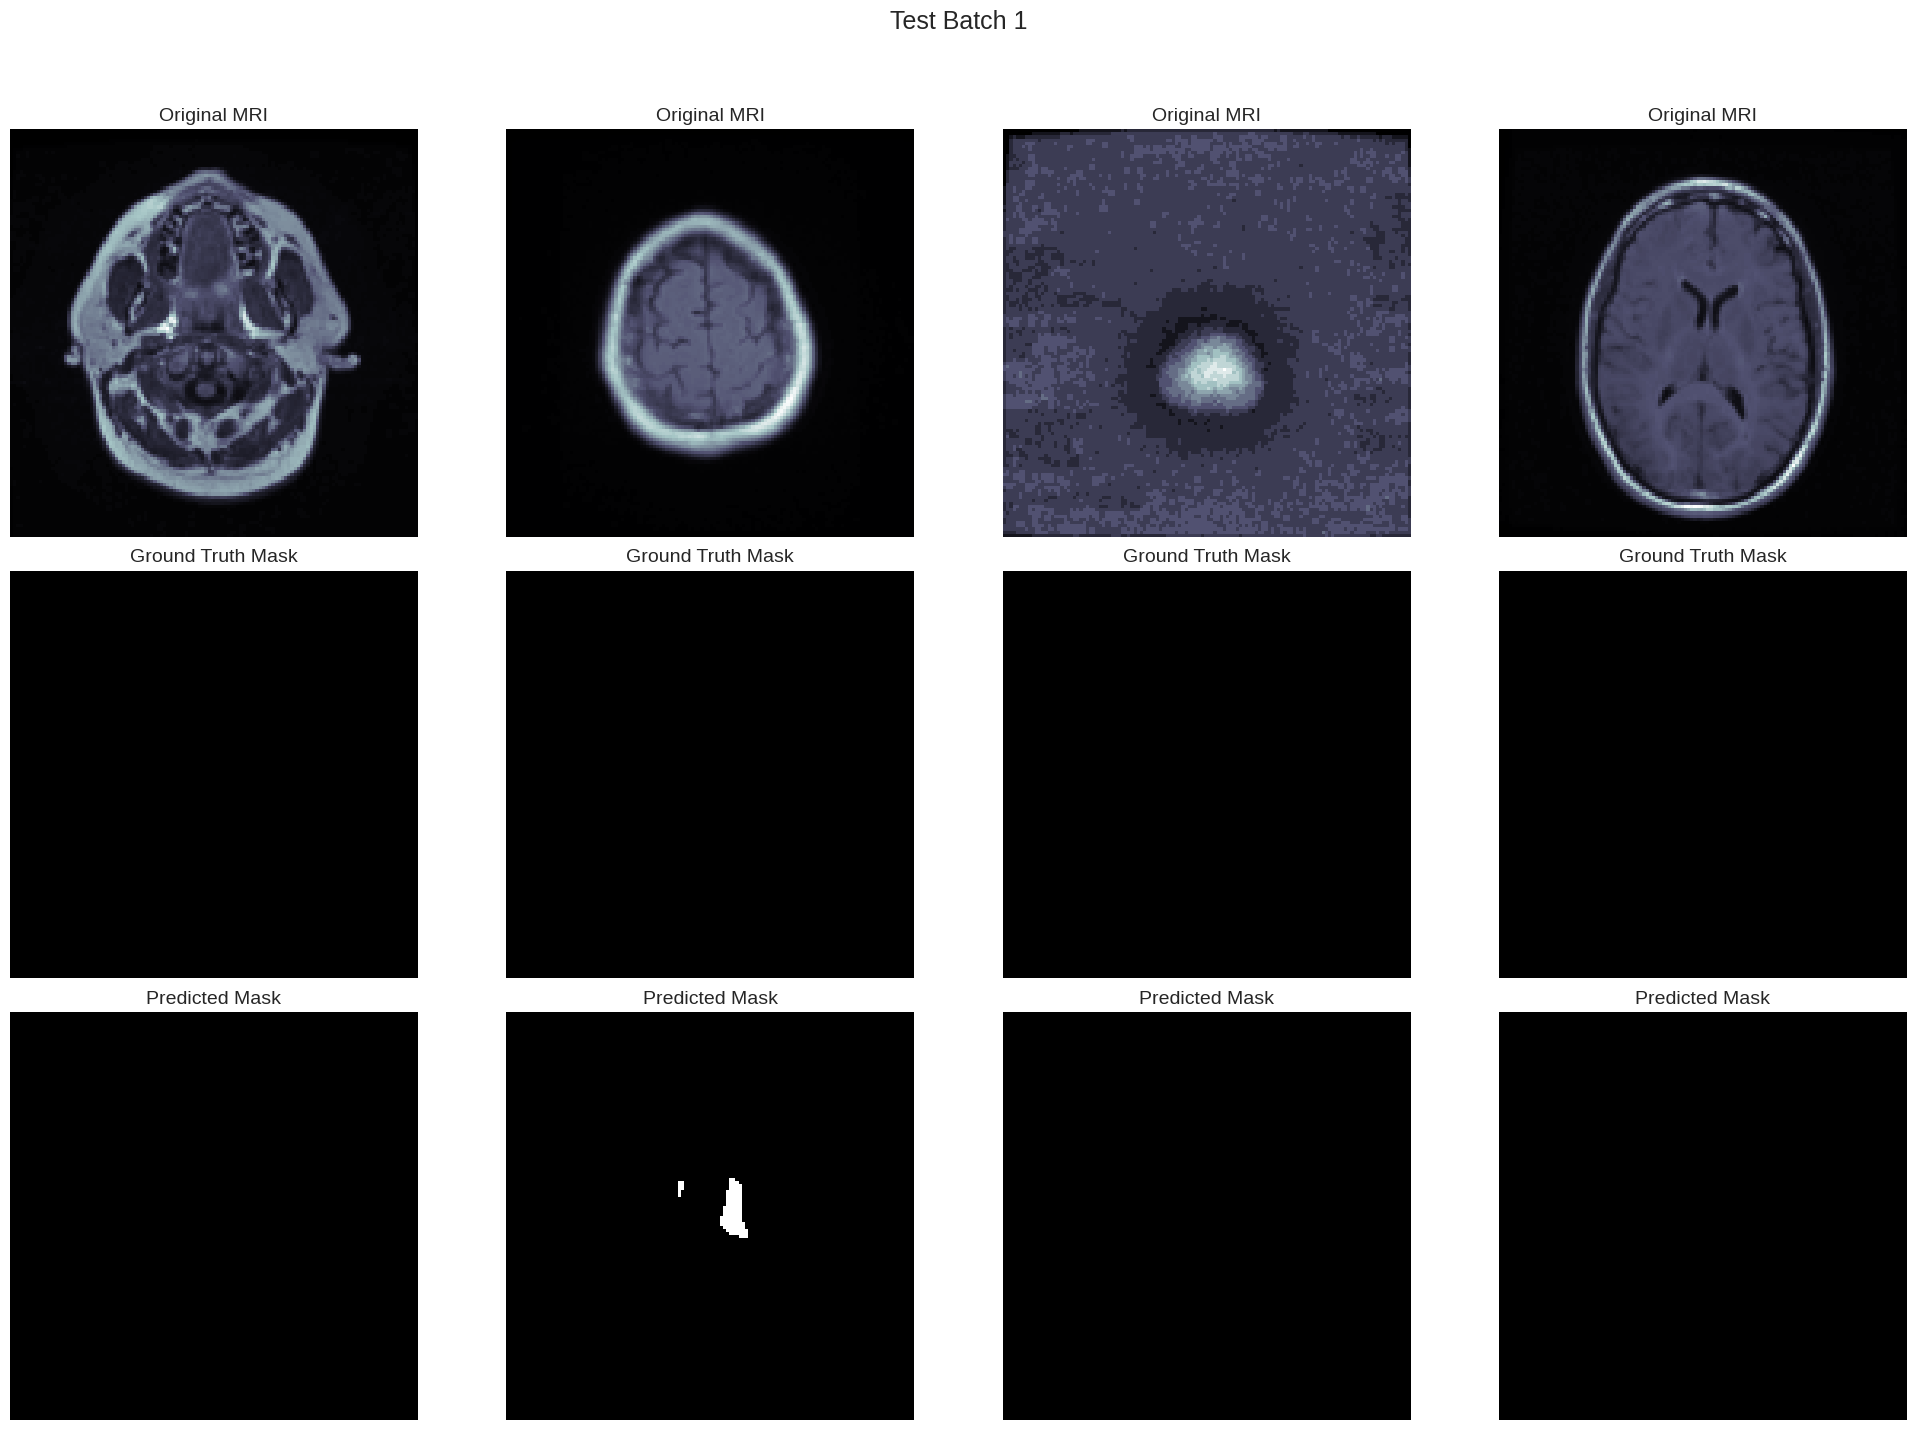

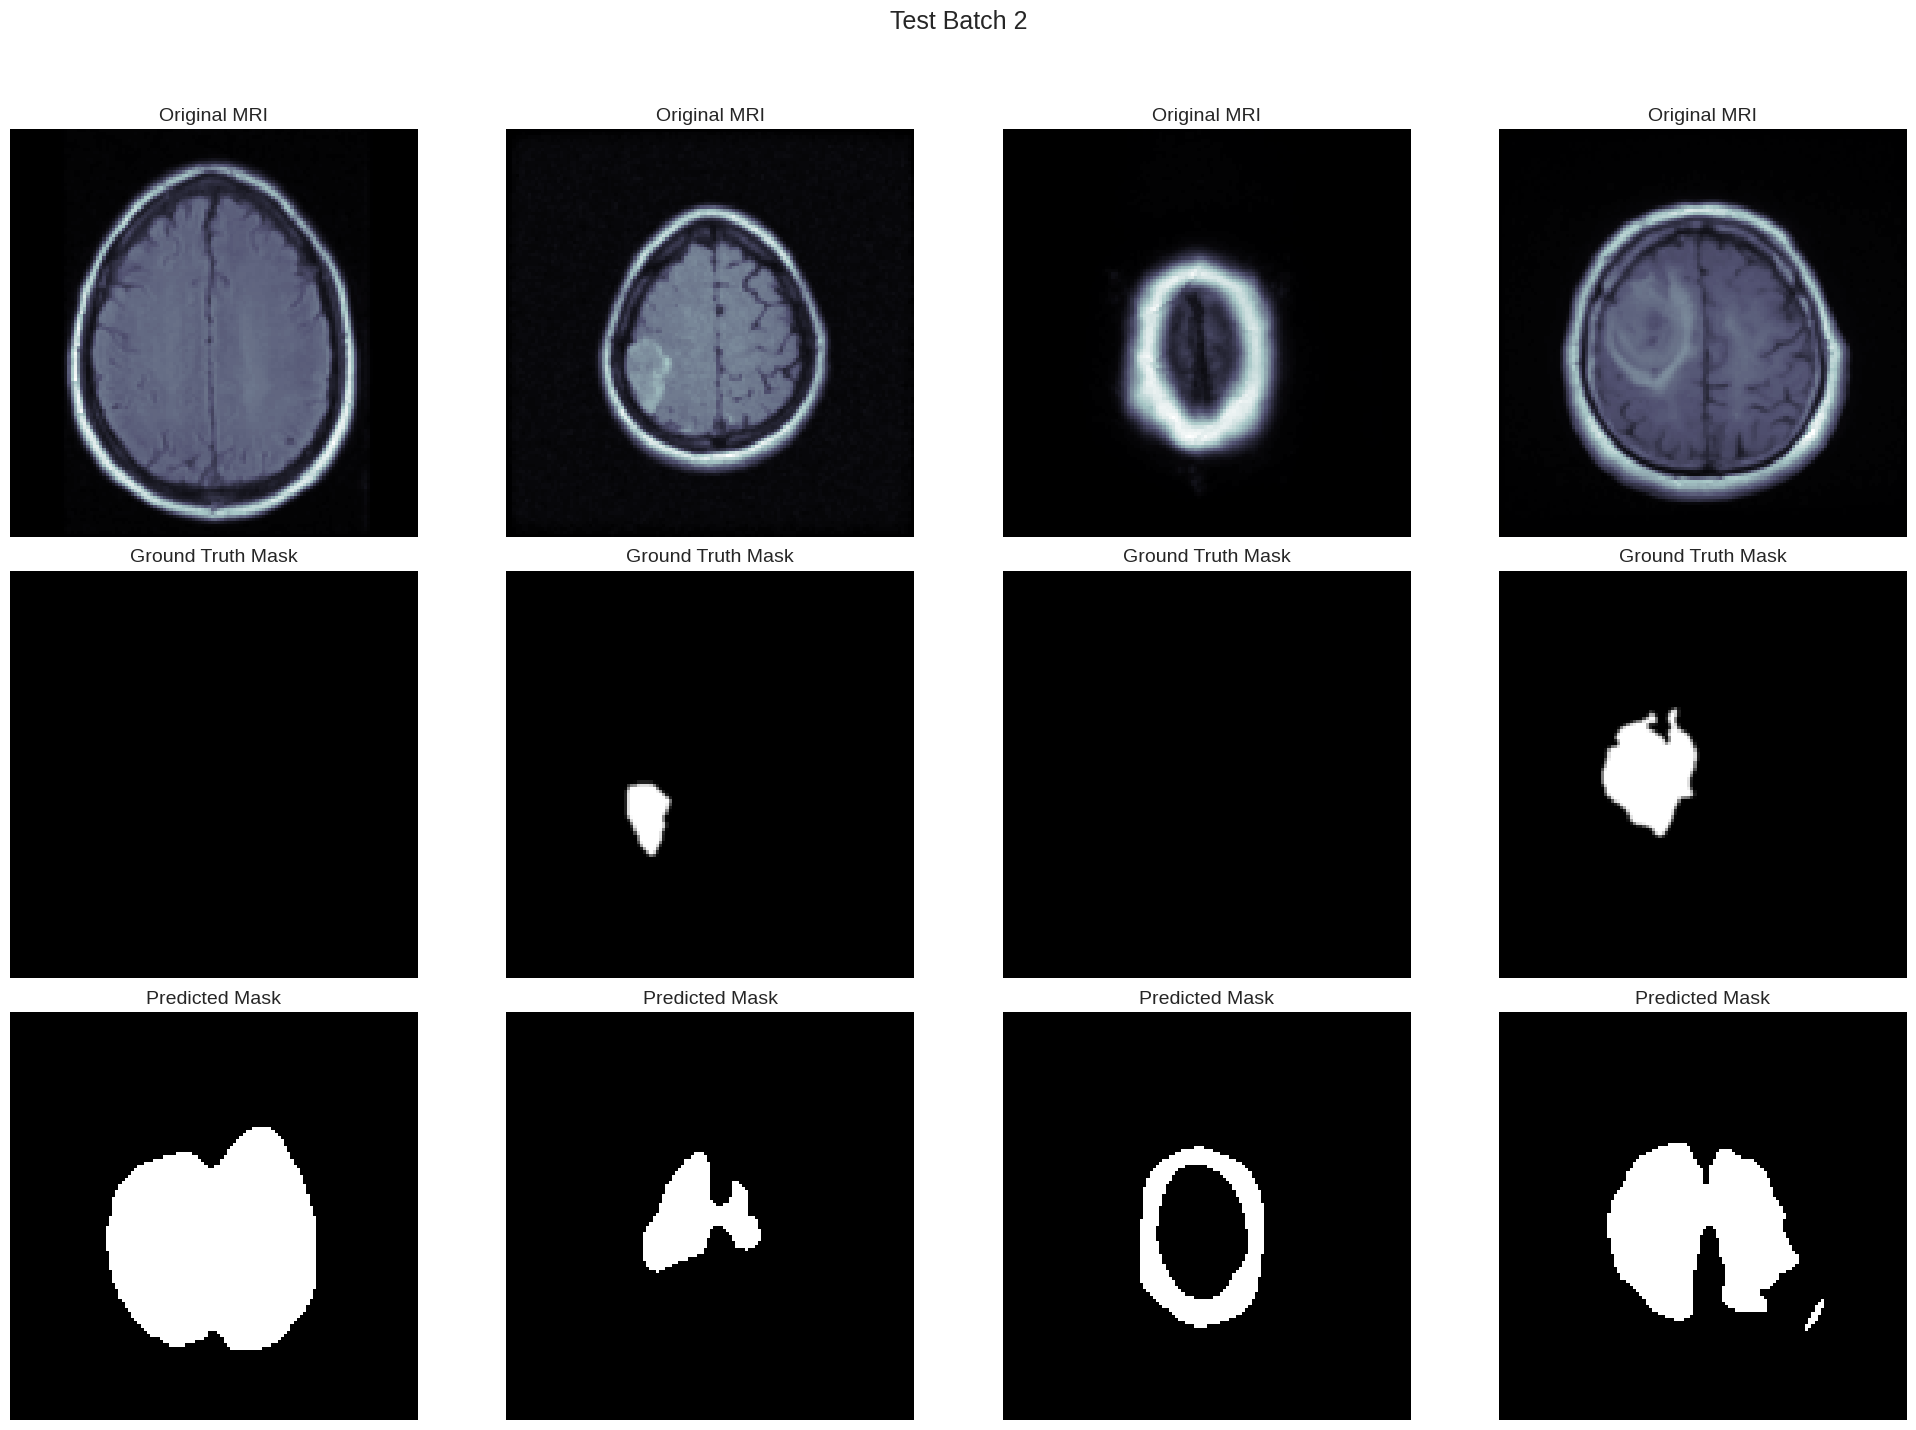

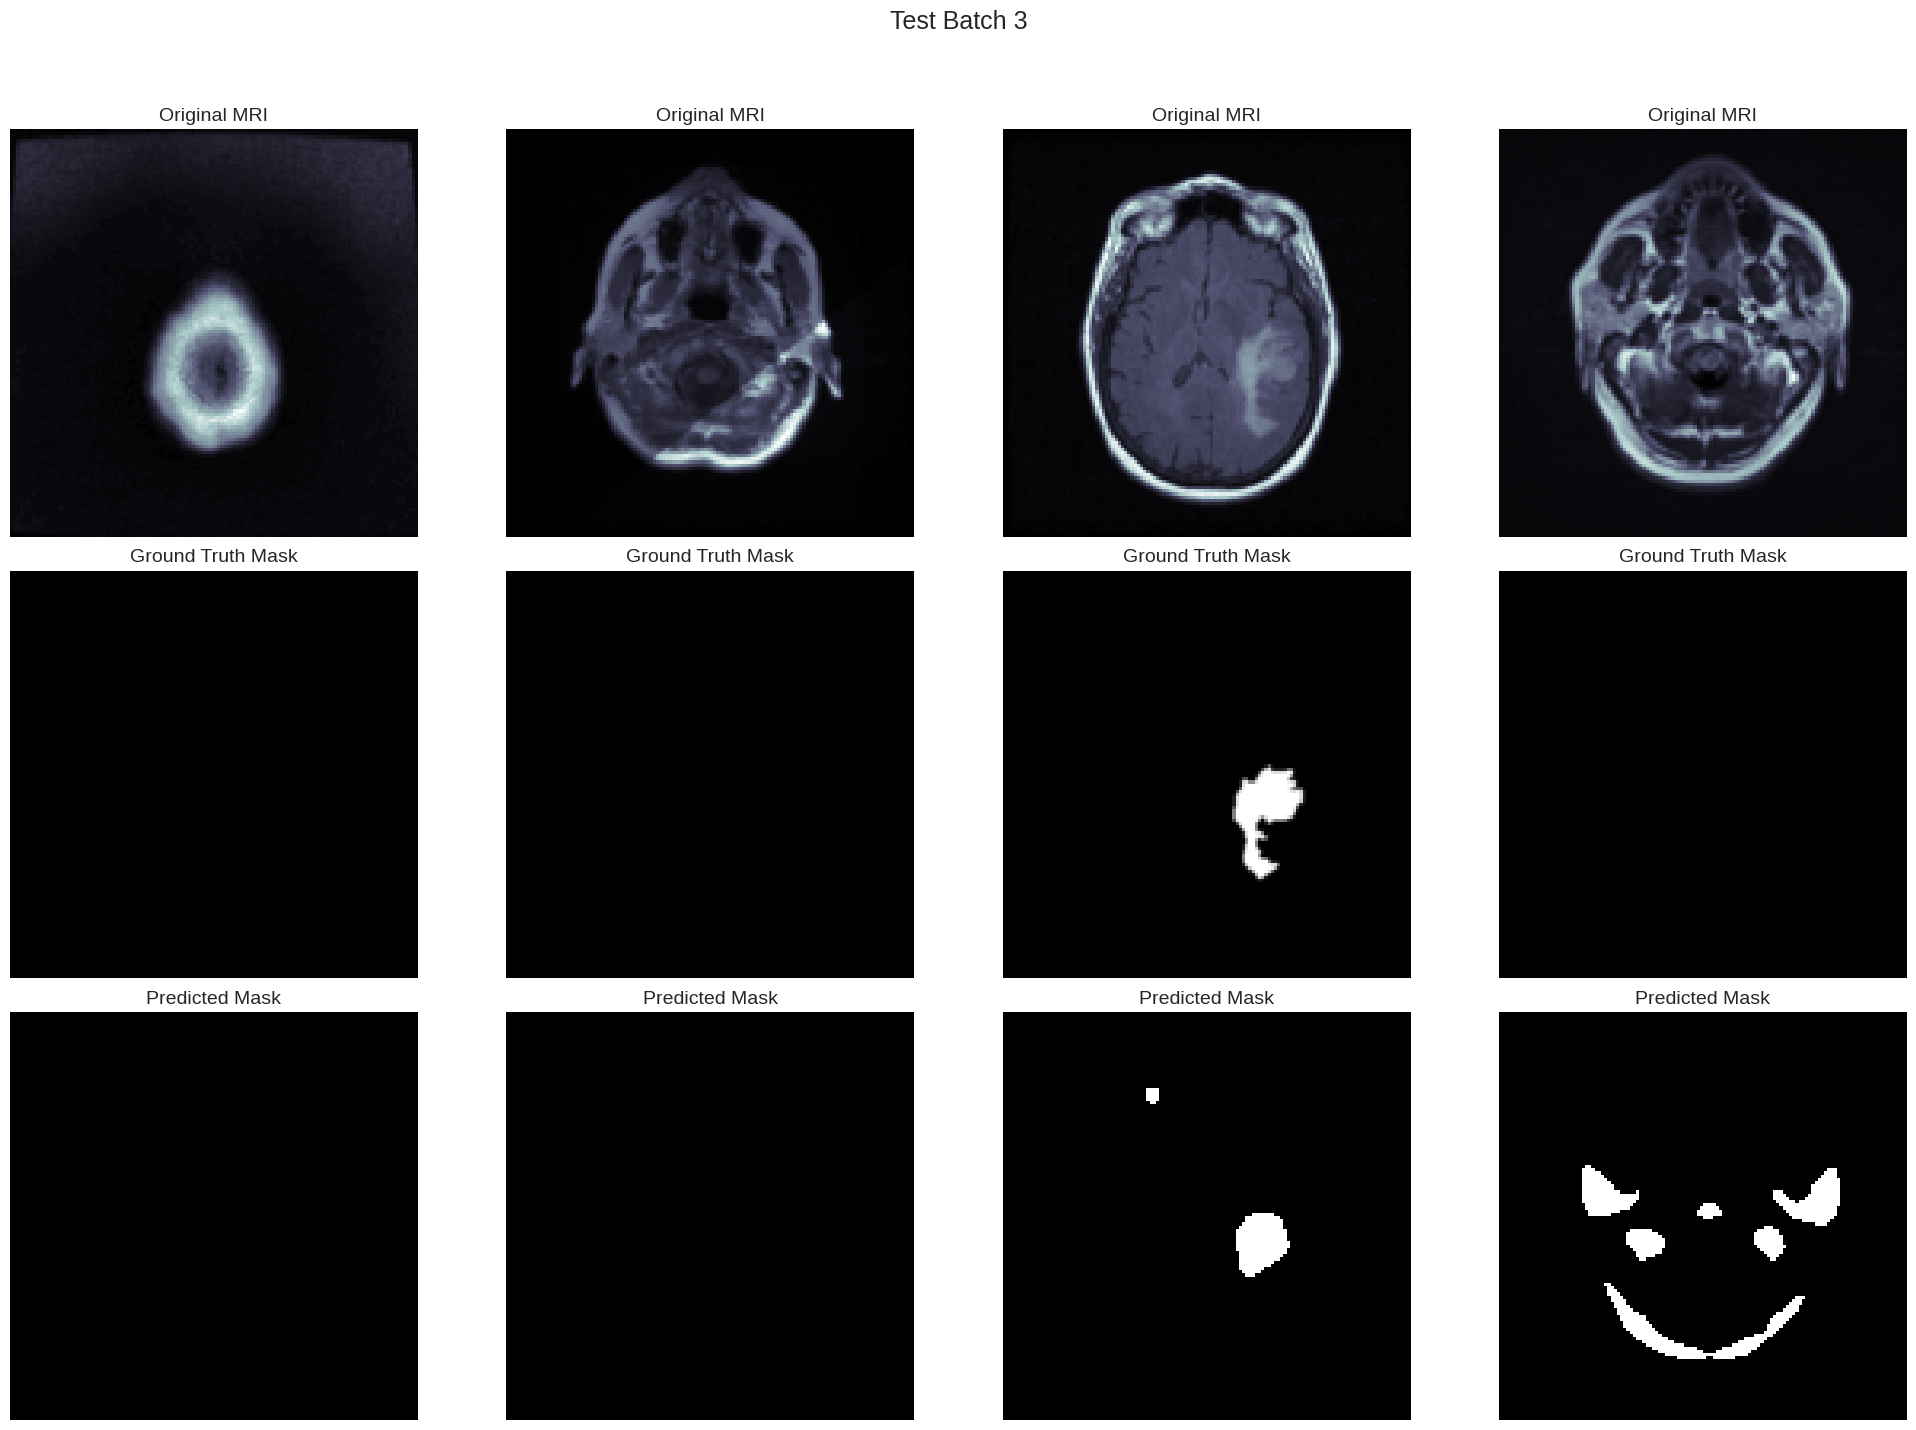

In [12]:
# 테스트 데이터셋 결과 시각화
model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        if i >= 3: # 처음 3개의 배치만 시각화
            break

        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # 예측 결과를 CPU로 옮기고 numpy 배열로 변환
        outputs = (outputs > 0.5).float().cpu().numpy() # 0.5를 기준으로 이진화
        masks = masks.cpu().numpy()
        images = images.cpu().numpy()

        # 결과 시각화
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle(f'Test Batch {i+1}', fontsize=18)

        for j in range(4): # 각 배치의 처음 4개 샘플만 시각화
            # 원본 이미지
            axes[0, j].imshow(images[j, 0, :, :], cmap='bone')
            axes[0, j].set_title('Original MRI', fontsize=14)
            axes[0, j].axis('off')

            # 실제 마스크
            axes[1, j].imshow(masks[j, 0, :, :], cmap='gray')
            axes[1, j].set_title('Ground Truth Mask', fontsize=14)
            axes[1, j].axis('off')

            # 예측 마스크
            axes[2, j].imshow(outputs[j, 0, :, :], cmap='gray')
            axes[2, j].set_title('Predicted Mask', fontsize=14)
            axes[2, j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()